# Earthquake Prediction

In [382]:
import math
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import catboost as cb
from sklearn import preprocessing, model_selection, linear_model
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, confusion_matrix, recall_score

In [383]:
filepath = './data/earthquakes.csv'

In [384]:
df = pd.read_csv(filepath)
df = df.set_index('time')
df.index = pd.to_datetime(df.index)
df = df.sort_index()
df.head()

,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,net,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
time,,,,,,,,,,,,,,,,,,,,,
2020-07-12 10:31:53.318000+00:00,67.791600,-158.636400,15.00,1.10,ml,NaN,NaN,NaN,0.42,ak,...,2020-08-04T02:49:26.410Z,"85 km NNW of Ambler, Alaska",earthquake,NaN,0.20,NaN,NaN,reviewed,ak,ak
2020-07-12 10:38:04.580000+00:00,33.177833,-116.127833,11.36,0.72,ml,35.0,60.0,0.040210,0.19,ci,...,2020-07-13T22:21:26.937Z,"4km N of Ocotillo Wells, CA",earthquake,0.24,0.34,0.158,12.0,reviewed,ci,ci
2020-07-12 10:38:50.280000+00:00,38.816334,-122.813500,3.17,0.91,md,22.0,46.0,0.007542,0.02,nc,...,2020-07-12T11:51:04.930Z,"7km NW of The Geysers, CA",earthquake,0.26,0.50,0.130,3.0,automatic,nc,nc
2020-07-12 10:40:29.962000+00:00,63.047100,-150.433700,107.20,1.10,ml,NaN,NaN,NaN,0.21,ak,...,2020-08-04T02:49:33.285Z,"63 km NNE of Petersville, Alaska",earthquake,NaN,0.50,NaN,NaN,reviewed,ak,ak
2020-07-12 10:50:55.660000+00:00,36.073167,-117.642167,4.75,0.88,ml,13.0,85.0,0.110600,0.14,ci,...,2020-07-12T16:37:38.032Z,"28km E of Coso Junction, CA",earthquake,0.27,2.64,0.189,9.0,reviewed,ci,ci


In [385]:
df.describe()

,latitude,longitude,depth,mag,nst,gap,dmin,rms,horizontalError,depthError,magError,magNst
count,35245.000000,35245.000000,35245.000000,35244.000000,28039.000000,29242.000000,24219.000000,35245.000000,24990.000000,35245.000000,26445.000000,27361.000000
mean,37.167296,-108.587333,21.477970,1.663011,23.384821,116.449267,0.816615,0.275335,1.929262,4.240555,0.252210,17.163664
std,19.093452,67.751199,54.360028,1.311471,21.687507,60.421071,2.755243,0.272876,3.300828,389.379273,0.461743,34.172450
min,-65.352200,-179.996400,-3.730000,-1.430000,0.000000,11.000000,0.000000,0.000000,0.080000,0.000000,0.000000,0.000000
25%,33.420500,-149.703200,3.600000,0.800000,10.000000,71.000000,0.025000,0.100000,0.280000,0.470000,0.103000,5.000000
50%,38.151200,-118.777667,8.000000,1.340000,17.000000,102.000000,0.059570,0.160000,0.480000,0.800000,0.160000,9.000000
75%,47.511900,-113.778167,14.560000,2.110000,29.000000,150.000000,0.165750,0.400000,1.090000,1.780000,0.236000,18.000000
max,87.349200,180.000000,647.998000,7.800000,444.000000,355.000000,43.236000,2.460000,26.400000,73091.100000,5.520000,760.000000


In [386]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35245 entries, 2020-07-12 10:31:53.318000+00:00 to 2022-10-06 13:10:10.910000+00:00
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   latitude         35245 non-null  float64
 1   longitude        35245 non-null  float64
 2   depth            35245 non-null  float64
 3   mag              35244 non-null  float64
 4   magType          35244 non-null  object 
 5   nst              28039 non-null  float64
 6   gap              29242 non-null  float64
 7   dmin             24219 non-null  float64
 8   rms              35245 non-null  float64
 9   net              35245 non-null  object 
 10  id               35245 non-null  object 
 11  updated          35245 non-null  object 
 12  place            34456 non-null  object 
 13  type             35245 non-null  object 
 14  horizontalError  24990 non-null  float64
 15  depthError       35245 non-null  float64
 1

In [387]:
df.isnull().sum()

latitude               0
longitude              0
depth                  0
mag                    1
magType                1
nst                 7206
gap                 6003
dmin               11026
rms                    0
net                    0
id                     0
updated                0
place                789
type                   0
horizontalError    10255
depthError             0
magError            8800
magNst              7884
status                 0
locationSource         0
magSource              0
dtype: int64

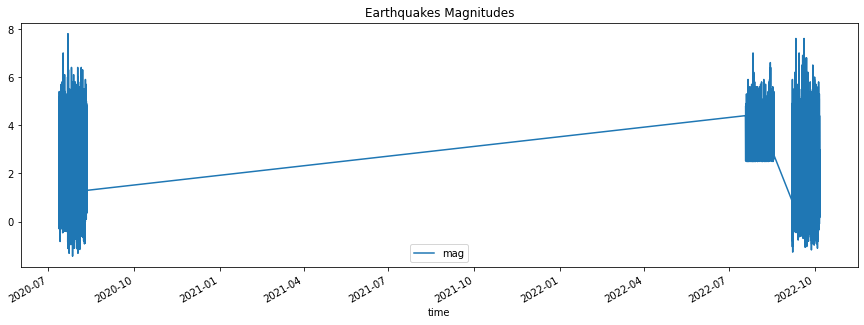

In [388]:
df.plot(figsize=(15, 5), title='Earthquakes Magnitudes', y='mag')
plt.show()

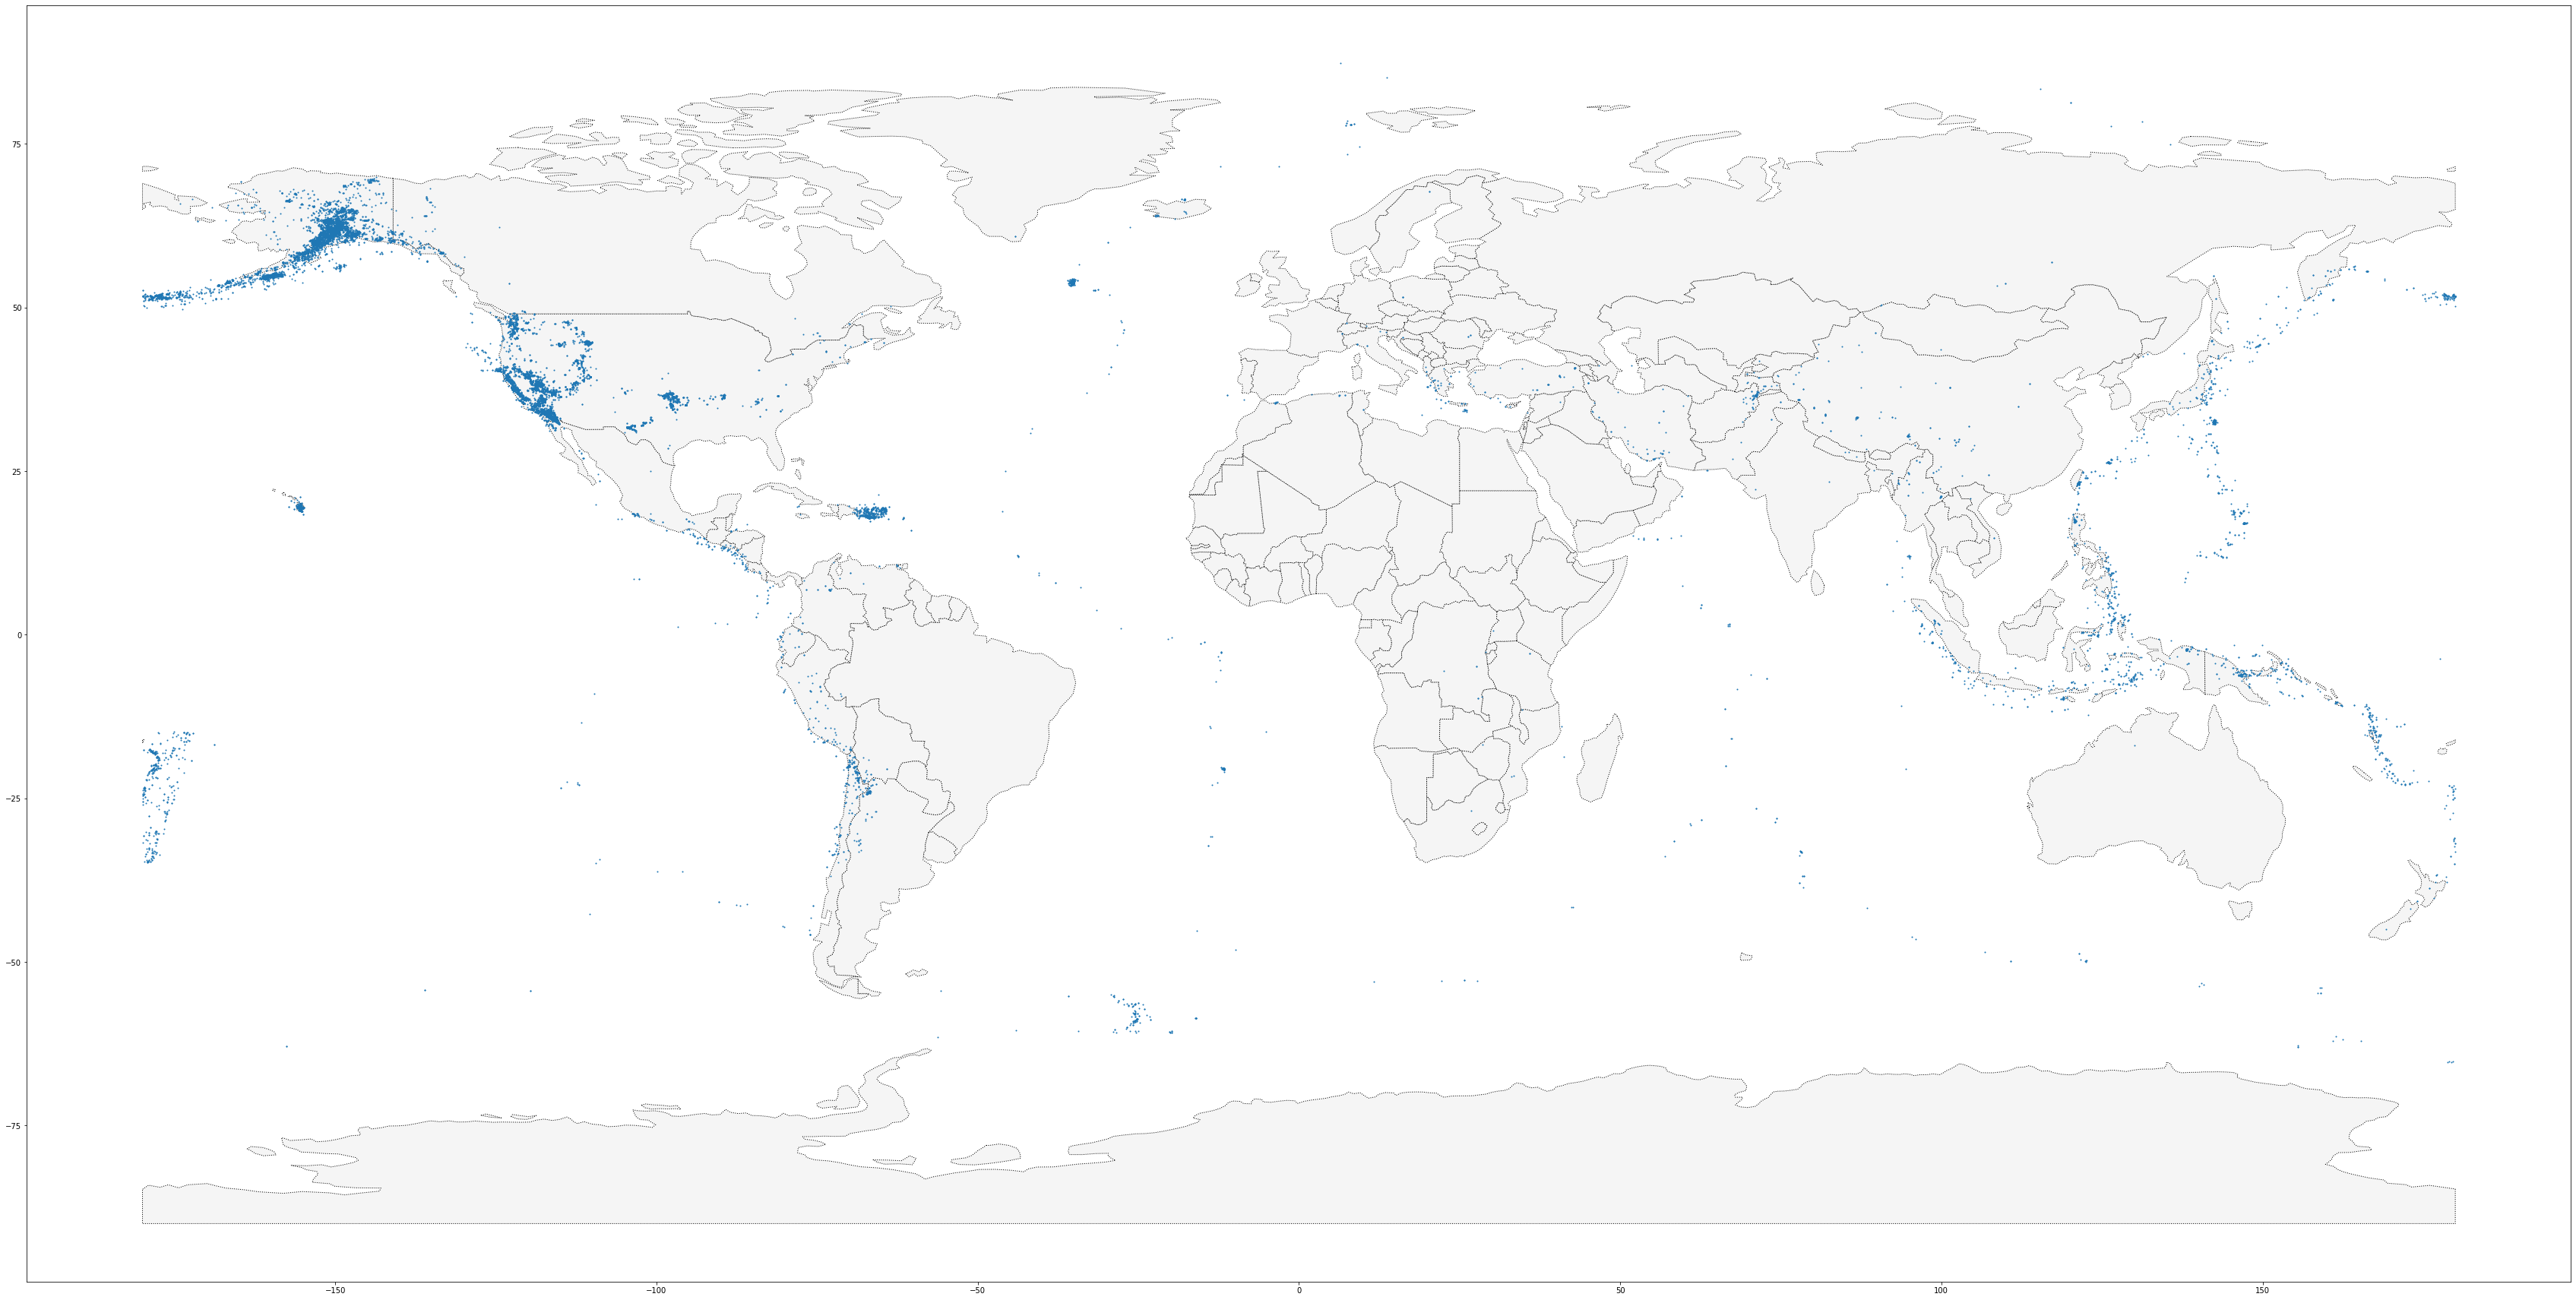

In [389]:
earthquakes = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
earthquakes.crs = 'EPSG:4326'

world_filepath = gpd.datasets.get_path('naturalearth_lowres')
world = gpd.read_file(world_filepath)

ax = world.plot(figsize=(60, 60), color='whitesmoke', linestyle=':', edgecolor='black')
earthquakes.to_crs(epsg=4326).plot(markersize=1, ax=ax)
plt.show()

In [390]:
print(f'Min magnitude: {df.mag.min()}')
print(f'Max magnitude: {df.mag.max()}')

Min magnitude: -1.43
Max magnitude: 7.8


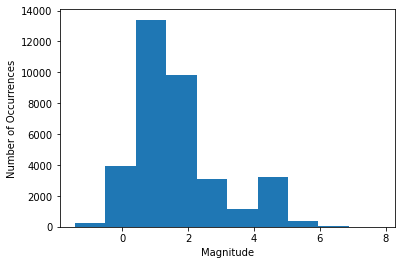

In [391]:
plt.hist(df.mag)
plt.xlabel('Magnitude')
plt.ylabel('Number of Occurrences')
plt.show()

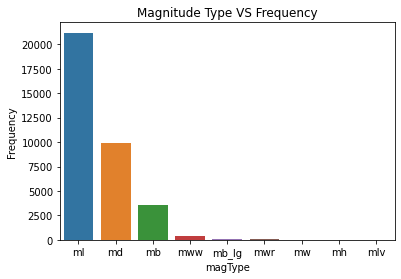

local magnitude (ML), surface-wave magnitude (Ms), body-wave magnitude (Mb), moment magnitude (Mw)


In [392]:
sns.countplot(data=df, x='magType')
plt.ylabel('Frequency')
plt.title('Magnitude Type VS Frequency')
plt.show()

print('local magnitude (ML), surface-wave magnitude (Ms), body-wave magnitude (Mb), moment magnitude (Mw)')

In [393]:
df.loc[df.mag >= 8, 'Class'] = 'Disastrous'
df.loc[(df.mag >= 7) & (df.mag < 7.9), 'Class'] = 'Major'
df.loc[(df.mag >= 6) & (df.mag < 6.9), 'Class'] = 'Strong'
df.loc[(df.mag >= 5.5) & (df.mag < 5.9), 'Class'] = 'Moderate'

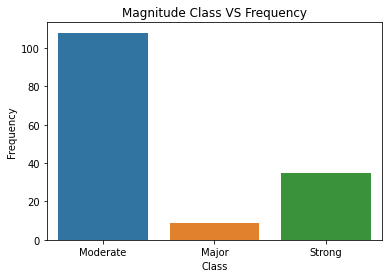

In [394]:
sns.countplot(data=df, x='Class')
plt.ylabel('Frequency')
plt.title('Magnitude Class VS Frequency')
plt.show()

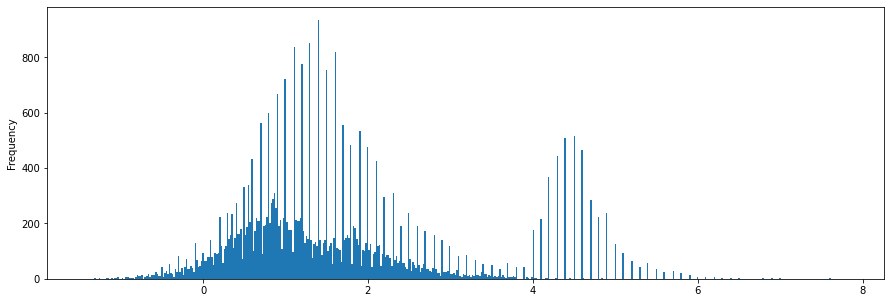

In [395]:
df.mag.plot(kind='hist', bins=500, figsize=(15, 5))
plt.show()

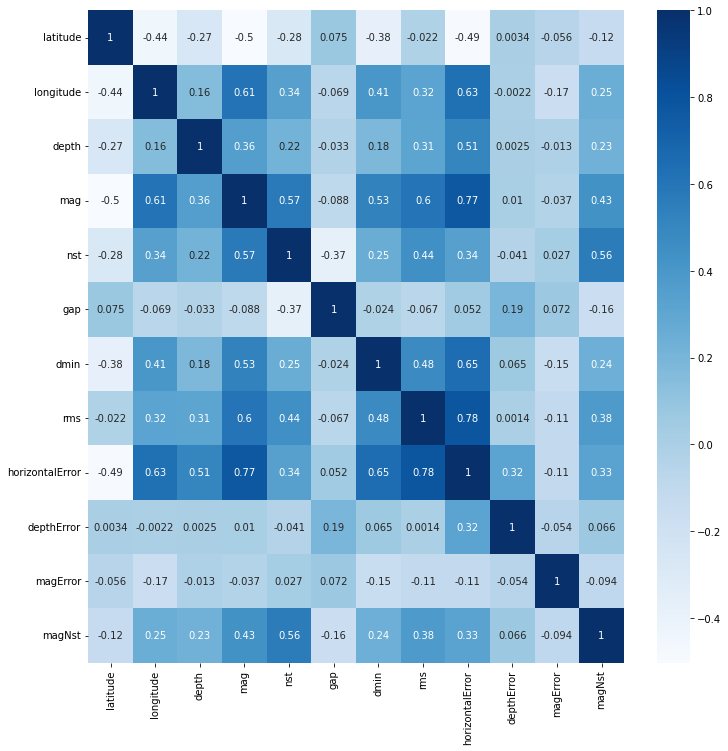

In [396]:
corr_matrix = df.corr() 
plt.figure(figsize=(12, 12))
sns.heatmap(corr_matrix, annot=True, cmap='Blues')
plt.show()

In [397]:
threshold = 0.9
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
df = df.drop(to_drop, axis=1)

In [398]:
for column in df.columns:
    if df[column].isna().mean() > 0.3:
        df = df.drop(column, axis=1) 

df = df.dropna(axis=0)

In [399]:
df.place = df.place.str.split(', ', expand=True)[1]
df.place.head() 

time
2020-07-12 10:38:04.580000+00:00    CA
2020-07-12 10:38:50.280000+00:00    CA
2020-07-12 10:50:55.660000+00:00    CA
2020-07-12 10:59:33.400000+00:00    CA
2020-07-12 11:08:48.240000+00:00    CA
Name: place, dtype: object

In [400]:
print(f'Total locations: {len(set(df.place))}')

Total locations: 120


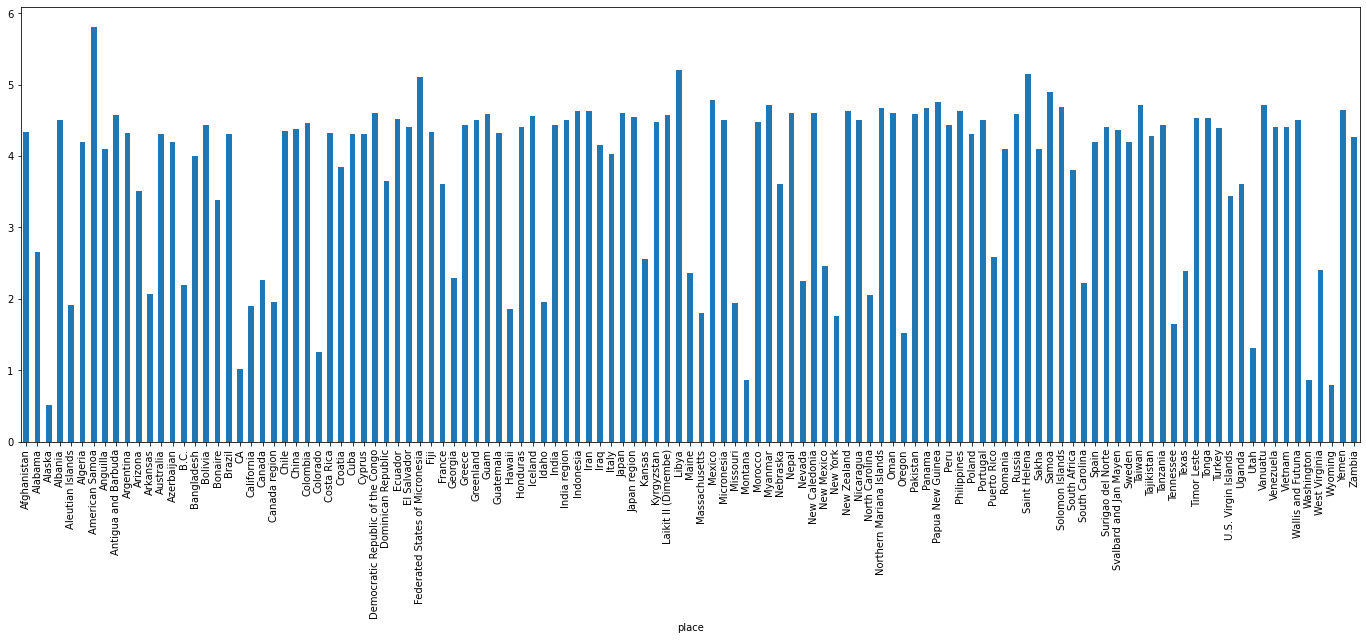

In [401]:
df.groupby(['place'])['mag'].mean().plot(kind='bar',figsize=(24, 8))
plt.show()

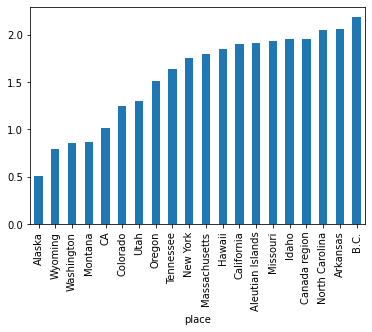

In [402]:
df.groupby(['place'])['mag'].mean().nsmallest(20).plot(kind='bar')
plt.show()

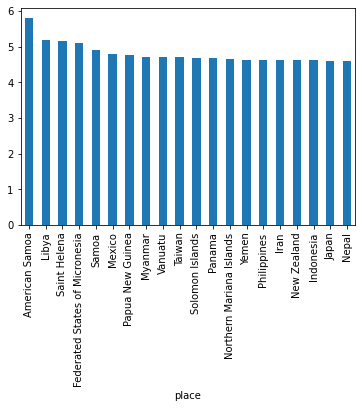

In [403]:
df.groupby(['place'])['mag'].mean().nlargest(20).plot(kind='bar')
plt.show()

In [404]:
def create_features(df: pd.DataFrame) -> pd.DataFrame:
    """Creates time series features based on time series index."""
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

def add_lags(df: pd.DataFrame) -> pd.DataFrame:
    df['mag_5d_lag'] = df.mag.shift(5)
    df['mag_10d_lag'] = df.mag.shift(10)
    df['mag_15d_lag'] = df.mag.shift(15)

    df['depth_5d_lag'] = df.depth.shift(5)
    df['depth_10d_lag'] = df.depth.shift(10)
    df['depth_15d_lag'] = df.depth.shift(15)
    return df

def add_rolling_window(df: pd.DataFrame) -> pd.DataFrame:
    df['mag_5d_avg'] = df.mag.rolling(window=5,center=False).mean() 
    df['mag_10d_avg'] = df.mag.rolling(window=10,center=False).mean() 
    df['mag_15d_avg'] = df.mag.rolling(window=15,center=False).mean()
    df['mag_5d_min'] = df.mag.rolling(window=5,center=False).min() 
    df['mag_10d_min'] = df.mag.rolling(window=10,center=False).min() 
    df['mag_15d_min'] = df.mag.rolling(window=15,center=False).min() 
    df['mag_5d_max'] = df.mag.rolling(window=5,center=False).max() 
    df['mag_10d_max'] = df.mag.rolling(window=10,center=False).max() 
    df['mag_15d_max'] = df.mag.rolling(window=15,center=False).max() 

    df['depth_5d_avg'] = df.depth.rolling(window=5,center=False).mean() 
    df['depth_10d_avg'] = df.depth.rolling(window=10,center=False).mean() 
    df['depth_15d_avg'] = df.depth.rolling(window=15,center=False).mean()
    df['depth_5d_min'] = df.depth.rolling(window=5,center=False).min() 
    df['depth_10d_min'] = df.depth.rolling(window=10,center=False).min() 
    df['depth_15d_min'] = df.depth.rolling(window=15,center=False).min() 
    df['depth_5d_max'] = df.depth.rolling(window=5,center=False).max() 
    df['depth_10d_max'] = df.depth.rolling(window=10,center=False).max() 
    df['depth_15d_max'] = df.depth.rolling(window=15,center=False).max()  
    return df

data = []
for place in list(set(df.place)):
    temp = df.loc[df.place == place]
    temp = create_features(temp)
    temp = add_lags(temp)
    temp = add_rolling_window(temp)

    data.append(temp)

df = pd.concat(data)

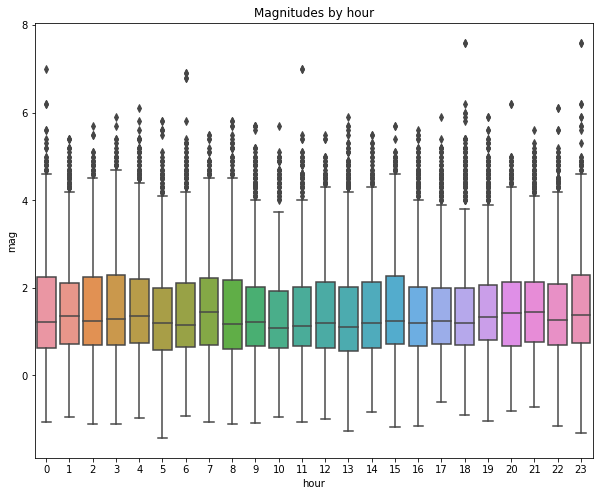

In [405]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='mag')
ax.set_title('Magnitudes by hour')
plt.show()

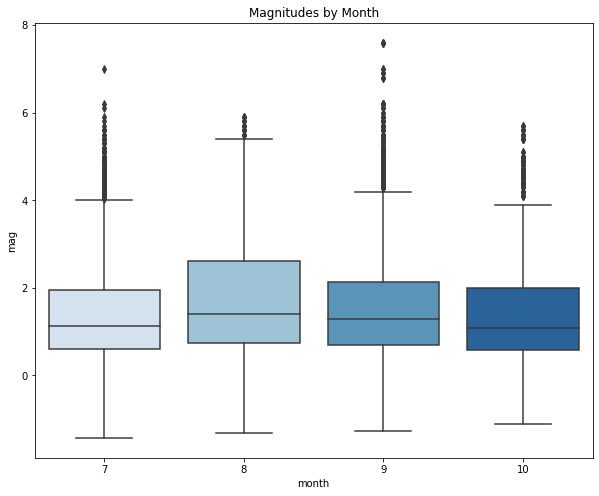

In [406]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='mag', palette='Blues')
ax.set_title('Magnitudes by Month')
plt.show()

In [407]:
features = [
    'dayofyear', 
    'hour', 
    'dayofweek', 
    'month', 
    'year', 
    'mag_5d_lag', 
    # 'mag_10d_lag', 
    # 'mag_15d_lag', 
    'mag_5d_avg',
    # 'mag_10d_avg', 
    # 'mag_15d_avg',
    'mag_5d_min',
    # 'mag_10d_min',
    # 'mag_15d_min',
    'mag_5d_max',
    # 'mag_10d_max',
    # 'mag_15d_max',
    # 'depth_5d_lag',
    # 'depth_10d_lag',
    # 'depth_15d_lag',
    # 'depth_5d_avg',
    # 'depth_10d_avg',
    # 'depth_15d_avg',
    # 'depth_5d_min',
    # 'depth_10d_min',
    # 'depth_15d_min',
    # 'depth_5d_max',
    # 'depth_10d_max',
    # 'depth_15d_max',
    'latitude', 
    'longitude',
]
cat_features = ['place']
target = 'mag'

In [408]:
date = '2022-09-23 00:00:00.000000+00:00'

df_train = df.loc[df.index < date]
df_train = df_train[features + cat_features + [target]]

df_test = df.loc[df.index >= date]
df_test = df_test[features + cat_features + [target]]

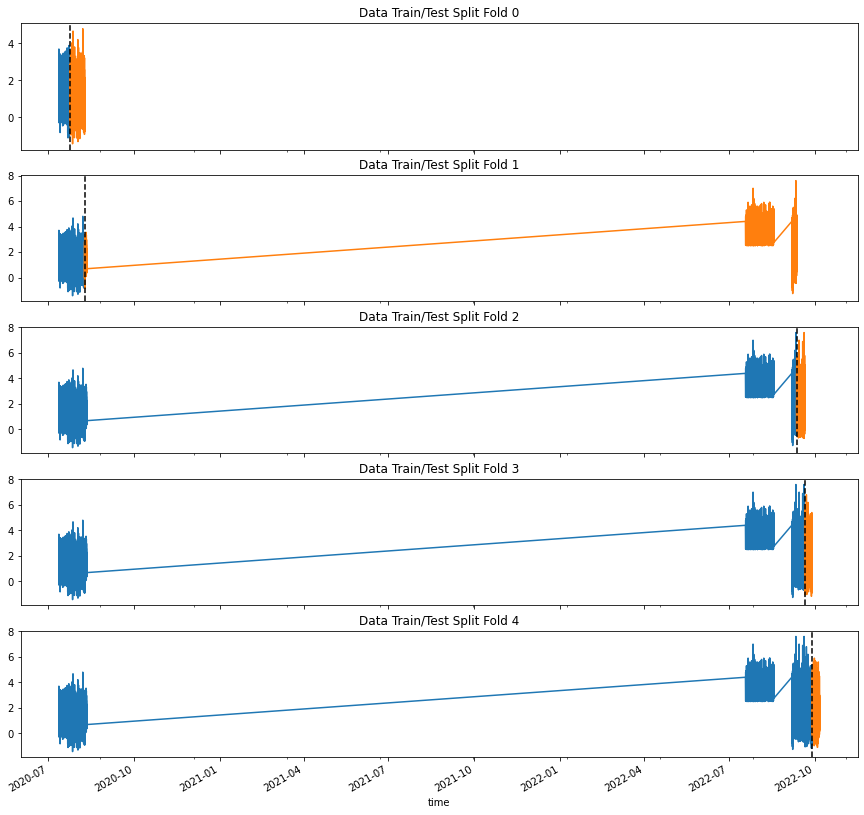

In [409]:
tss = model_selection.TimeSeriesSplit(n_splits=5, test_size=3600, gap=24)
df = df.sort_index()

fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train.mag.plot(ax=axs[fold], label='Training Set', title=f'Data Train/Test Split Fold {fold}')
    test.mag.plot(ax=axs[fold], label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1

plt.show()

In [410]:
fold = 0
predictions = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    x_train = train[features + cat_features]
    y_train = train[target]

    x_test = test[features + cat_features]
    y_test = test[target]

    model = cb.CatBoostRegressor(
        depth=7, 
        learning_rate=0.01, 
        iterations=1000, 
        early_stopping_rounds=50, 
        cat_features=cat_features
    )
    model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_test, y_test)], verbose=100)

    y_pred = model.predict(x_test)
    predictions.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

0:	learn: 0.7914226	test: 0.7914226	test1: 0.8140660	best: 0.8140660 (0)	total: 3.94ms	remaining: 3.93s
100:	learn: 0.5495846	test: 0.5495846	test1: 0.5891050	best: 0.5891050 (100)	total: 364ms	remaining: 3.24s
200:	learn: 0.4827396	test: 0.4829117	test1: 0.5229849	best: 0.5229849 (200)	total: 648ms	remaining: 2.57s
300:	learn: 0.4570264	test: 0.4577315	test1: 0.4988670	best: 0.4988670 (300)	total: 936ms	remaining: 2.17s
400:	learn: 0.4419388	test: 0.4430364	test1: 0.4875231	best: 0.4875231 (400)	total: 1.21s	remaining: 1.8s
500:	learn: 0.4306231	test: 0.4320049	test1: 0.4809568	best: 0.4809568 (500)	total: 1.63s	remaining: 1.63s
600:	learn: 0.4200369	test: 0.4217232	test1: 0.4752343	best: 0.4752343 (600)	total: 1.93s	remaining: 1.28s
700:	learn: 0.4114189	test: 0.4133524	test1: 0.4718799	best: 0.4718613 (698)	total: 2.27s	remaining: 969ms
800:	learn: 0.4032929	test: 0.4054143	test1: 0.4691485	best: 0.4691485 (800)	total: 2.55s	remaining: 633ms
900:	learn: 0.3962022	test: 0.3984875	tes

In [411]:
print(f'Score across folds {np.mean(scores)}')
print(f'Fold scores:{scores}')

Score across folds 0.5851394410415824
Fold scores:[0.4641239574873621, 1.0328158431568633, 0.5077351519964787, 0.46894538161819393, 0.45207687094901366]


In [412]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(
    df_train[features + cat_features],
    df_train[target], 
    test_size=0.2, 
    random_state=42,
)

In [413]:
grid = {
    'depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01],
    'iterations': [1000],
}

model = cb.CatBoostRegressor(early_stopping_rounds=50, cat_features=cat_features)
grid_search_result = model.grid_search(grid, x_train, y_train, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 2.0430135	test: 2.0401033	best: 2.0401033 (0)	total: 9.95ms	remaining: 9.94s
1:	learn: 2.0251454	test: 2.0221984	best: 2.0221984 (1)	total: 16.4ms	remaining: 8.21s
2:	learn: 2.0077885	test: 2.0047420	best: 2.0047420 (2)	total: 22.8ms	remaining: 7.57s
3:	learn: 1.9899742	test: 1.9869345	best: 1.9869345 (3)	total: 26.7ms	remaining: 6.64s
4:	learn: 1.9724697	test: 1.9693987	best: 1.9693987 (4)	total: 28.9ms	remaining: 5.76s
5:	learn: 1.9553319	test: 1.9522897	best: 1.9522897 (5)	total: 31.1ms	remaining: 5.15s
6:	learn: 1.9387538	test: 1.9356499	best: 1.9356499 (6)	total: 33.6ms	remaining: 4.76s
7:	learn: 1.9222248	test: 1.9190351	best: 1.9190351 (7)	total: 35.7ms	remaining: 4.43s
8:	learn: 1.9063174	test: 1.9029196	best: 1.9029196 (8)	total: 37.6ms	remaining: 4.14s
9:	learn: 1.8895798	test: 1.8861808	best: 1.8861808 (9)	total: 39.2ms	remaining: 3.88s
10:	learn: 1.8739327	test: 1.8702817	best: 1.8702817 (10)	total: 40.9ms	remaining: 3.68s
11:	learn: 1.8580163	test: 1.8543521	best

In [414]:
grid_search_result['params']

{'depth': 7, 'iterations': 1000, 'learning_rate': 0.01}

In [415]:
prediction = model.predict(x_test)
print(f'Accuracy of Model: {model.score(x_test, y_test)}')
print(f'Mean Absolute Error: {mean_absolute_error(y_test, prediction)}')
print(f'Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test, prediction))}')

Accuracy of Model: 0.8887777596946597
Mean Absolute Error: 0.33887529491531193
Root Mean Squared Error: 0.4466534148637133


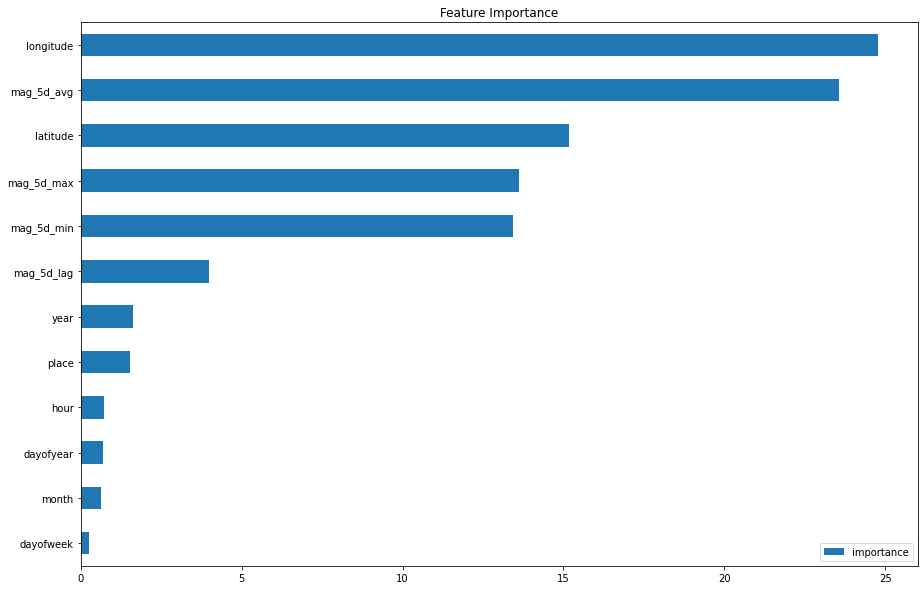

In [416]:
fi = pd.DataFrame(data=model.feature_importances_, index=model.feature_names_, columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance', figsize=(15, 10))
plt.show()

Accuracy of Model: 0.857651331120201
Mean Absolute Error: 0.35106017953577084
Root Mean Squared Error: 0.46847699301254797


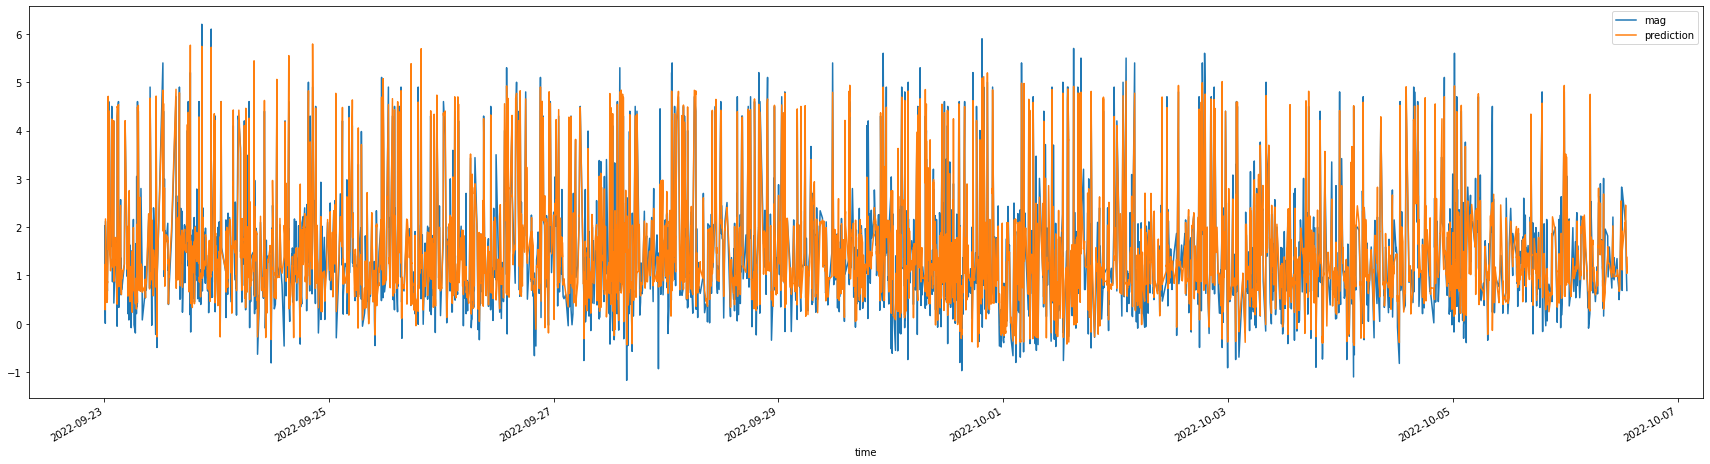

In [417]:
prediction = model.predict(df_test[features + cat_features])
print(f'Accuracy of Model: {model.score(df_test[features + cat_features], df_test[target])}')
print(f'Mean Absolute Error: {mean_absolute_error(df_test[target], prediction)}')
print(f'Root Mean Squared Error: {np.sqrt(mean_squared_error(df_test[target], prediction))}')

df_plot = pd.DataFrame({'mag': df_test[target], 'prediction': prediction}, index=df_test.index)
df_plot = df_plot[::-1]
df_plot.plot(figsize=(30, 8))
plt.show()

In [418]:
live_data = pd.read_csv('https://earthquake.usgs.gov/fdsnws/event/1/query?format=csv&eventtype=earthquake')
live_data = live_data.set_index('time')
live_data.index = pd.to_datetime(live_data.index)
live_data = live_data.sort_index()
live_data = live_data.dropna(axis=0)

data = []
for place in list(set(live_data.place)):
    temp = live_data.loc[live_data.place == place]
    temp = create_features(temp)
    temp = add_lags(temp)
    temp = add_rolling_window(temp)

    data.append(temp)

live_data = pd.concat(data)

Accuracy of Model: 0.7418779663672364
Mean Absolute Error: 0.599346426566118
Root Mean Squared Error: 0.7704164657654332


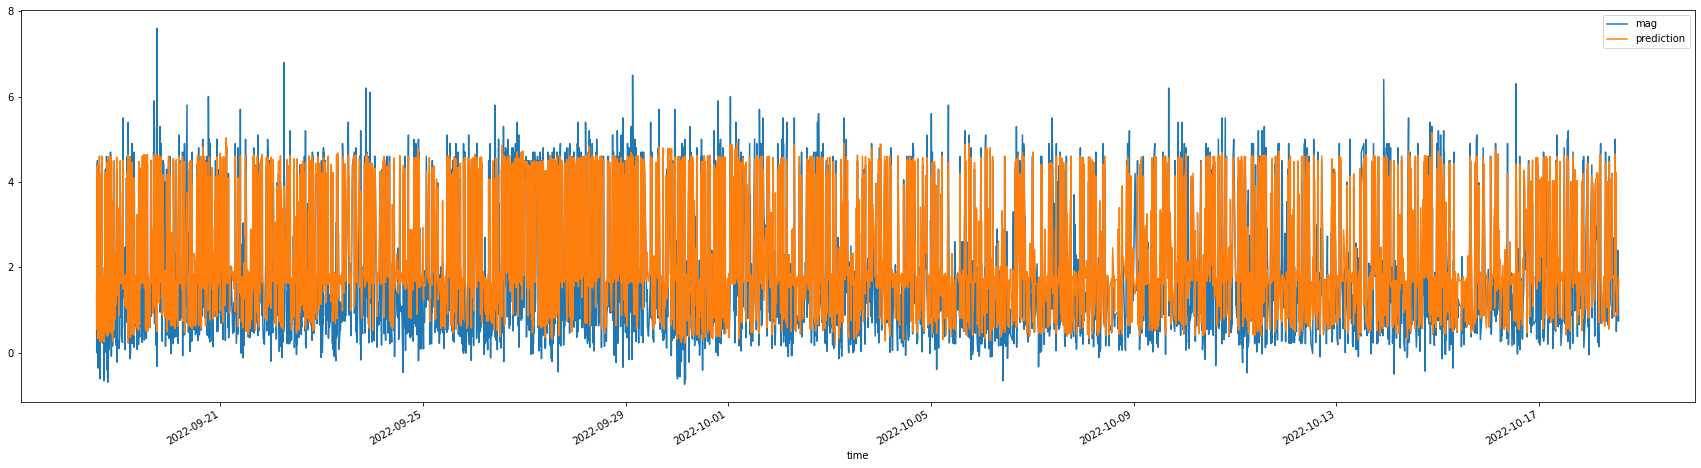

In [419]:
live_prediction = model.predict(live_data[features + cat_features])
print(f'Accuracy of Model: {model.score(live_data[features + cat_features], live_data[target])}')
print(f'Mean Absolute Error: {mean_absolute_error(live_data[target], live_prediction)}')
print(f'Root Mean Squared Error: {np.sqrt(mean_squared_error(live_data[target], live_prediction))}')

df_live = pd.DataFrame({'mag': live_data[target], 'prediction': live_prediction}, index=live_data.index)
df_live = df_live[::-1]
df_live.plot(figsize=(30, 8))
plt.show()

In [420]:
# model.save_model('../app/server/app/ml/model')